In [3]:
import pandas as pd
import sklearn as sk
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

    Handled_by_SLHS  Check_In_Timestamp  Final_Checkpoint_Timestamp  \
12                0          1741112940                  1741119060   
13                0          1741071060                  1741077420   
14                0          1741051920                  1741061280   
15                0          1741112940                  1741123740   
16                0          1741112220                  1741114680   

    Check_In_Hour  Check_In_DayOfWeek  Time_in_Transit_Minutes  
12           18.0                 1.0                      102  
13            6.0                 1.0                      106  
14            1.0                 1.0                      156  
15           18.0                 1.0                      180  
16           18.0                 1.0                       41  
Epoch 1/50


C:\Users\USER\AppData\Local\Temp\ipykernel_29028\4130543837.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['Handled_by_SLHS'] = dataset['Handled_by_SLHS'].fillna(False).astype(bool).astype(int)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9176 - mae: 0.8270 - val_loss: 0.8084 - val_mae: 0.7816
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8238 - mae: 0.7924 - val_loss: 0.7087 - val_mae: 0.7310
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6583 - mae: 0.6952 - val_loss: 0.6173 - val_mae: 0.6812
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5863 - mae: 0.6609 - val_loss: 0.5332 - val_mae: 0.6311
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5212 - mae: 0.6218 - val_loss: 0.4540 - val_mae: 0.5802
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4300 - mae: 0.5647 - val_loss: 0.3799 - val_mae: 0.5283
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3576 - mae: 0.5015 - val_loss: 0.3128 - val_mae: 0.4769
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3176 - mae: 0.4838 - val_loss: 0.2524 - val_mae: 0.4259
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2412 - mae: 0.4151 - 

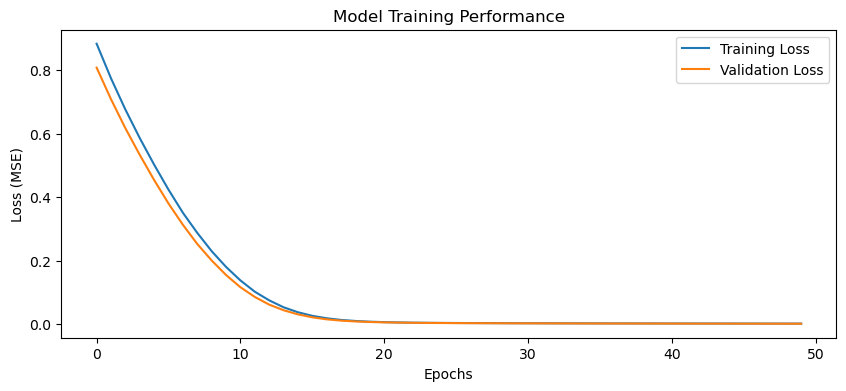

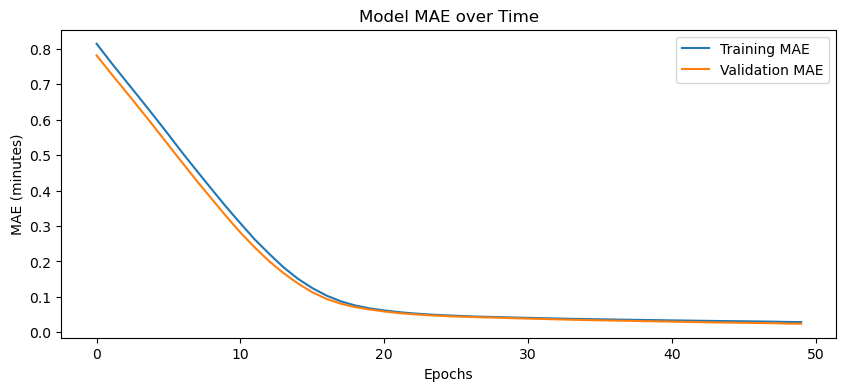

In [4]:
dataset = pd.read_csv('C:/Users/USER/Desktop/A/luggage_data_sle.csv')  
dataset = dataset.dropna(subset=["Bag_ID"])

dataset = dataset.drop(columns=['Flight_Number','Phone_Number', 'Bag_ID', 'Reservation_ID', 'Number_of_Bags', 'Claim_Option', 'Delivery_Address', 'Delivery_Address','Check_In_Time', 'Final_Checkpoint_Time', 'Estimated_Arrival_Time', 'Time_in_Transit' ], errors='ignore') # Remove temporary column
dataset['Handled_by_SLHS'] = dataset['Handled_by_SLHS'].fillna(False).astype(bool).astype(int)
print(dataset.head()) 

# Preprocess categorical features (One-Hot Encoding)
#encoder = OneHotEncoder(sparse_output=False)
#categorical_features = encoder.fit_transform(dataset[["luggage_status"]])

# Normalize numerical features
scaler = StandardScaler()
numerical_features = scaler.fit_transform(dataset[["Check_In_Timestamp", "Final_Checkpoint_Timestamp", "Check_In_Hour", "Check_In_DayOfWeek", "Time_in_Transit_Minutes"]])
handled_by_SLHS = dataset['Handled_by_SLHS'].values.reshape(-1, 1)

target_scaler = StandardScaler()
dataset["Final_Checkpoint_Timestamp"] = target_scaler.fit_transform(dataset[["Final_Checkpoint_Timestamp"]])

# Combine features
X = np.hstack([numerical_features, handled_by_SLHS])
y = dataset["Final_Checkpoint_Timestamp"].values  # Assuming it's in minutes

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


input_layer = keras.Input(shape=(X_train.shape[1], 1))

# Define model
model = keras.Sequential([
    input_layer,
    layers.Conv1D(filters=64, kernel_size=2, activation="relu"),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)  # Output layer for regression
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss="mse", metrics=["mae"])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Convert MAE from minutes to hours and minutes
mae_minutes = history.history["mae"][-1]  # Last epoch MAE
mae_hours = int(mae_minutes // 60)
mae_remaining_minutes = int(mae_minutes % 60)

print(f"Final MAE: {mae_hours} hours, {mae_remaining_minutes} minutes")

test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae:.4f} minutes")

 #Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Model Training Performance")
plt.legend()
plt.show()

# Plot MAE
plt.figure(figsize=(10, 4))
plt.plot(history.history["mae"], label="Training MAE")
plt.plot(history.history["val_mae"], label="Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE (minutes)")
plt.title("Model MAE over Time")
plt.legend()
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_29028\1026915776.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['Handled_by_SLHS'] = dataset['Handled_by_SLHS'].fillna(False).astype(bool).astype(int)
Training Models:   0%|          | 0/4 [00:00<?, ?model/s]

Linear Regression: Average R² Score = 1.0000


Training Models: 100%|██████████| 4/4 [00:01<00:00,  3.23model/s]

Random Forest: Average R² Score = 0.9984
Support Vector Regressor: Average R² Score = 0.9963
K-Nearest Neighbors: Average R² Score = 0.9928

Best performing model: Linear Regression with R² Score of 1.0000


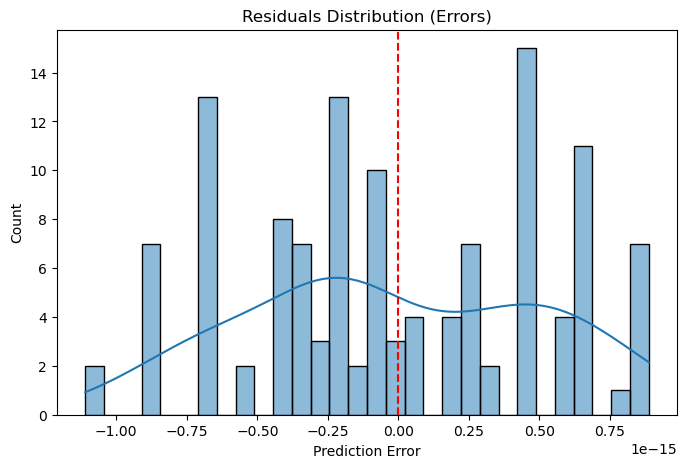

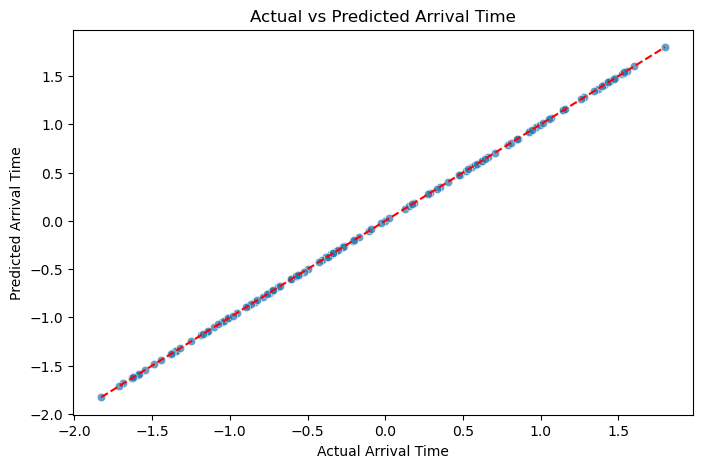

Final MAE: 0 hours, 0 minutes
Test MAE: 0.0000 minutes


In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from tqdm import tqdm

# Load and clean dataset
dataset = pd.read_csv('C:/Users/USER/Desktop/A/luggage_data_sle.csv')
dataset = dataset.dropna(subset=["Bag_ID"])


# Drop unnecessary columns
dataset = dataset.drop(columns=['Flight_Number', 'Phone_Number', 'Bag_ID', 'Reservation_ID', 'Number_of_Bags',
                                'Claim_Option', 'Delivery_Address', 'Check_In_Time', 'Final_Checkpoint_Time', 'Time_in_Transit'], errors='ignore')

# Convert boolean column
dataset['Handled_by_SLHS'] = dataset['Handled_by_SLHS'].fillna(False).astype(bool).astype(int)

# Define target variable (y) and features (X)
y = dataset["Final_Checkpoint_Timestamp"].values  # Target variable
X = dataset.drop(columns=["Final_Checkpoint_Timestamp"])  # Features without target

# Train-test split (before scaling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize numerical features in X (without `Final_Checkpoint_Timestamp`)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  # Use the same scaler on test data

# Normalize target variable separately
target_scaler = StandardScaler()
y_train = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = target_scaler.transform(y_test.reshape(-1, 1)).flatten()


# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Support Vector Regressor": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5)
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
model_results = {}

# Loop through models, train, and evaluate
for name, model in tqdm(models.items(), desc="Training Models", unit="model"):
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring="r2")
    avg_score = np.mean(cv_scores)
    model_results[name] = avg_score
    print(f"{name}: Average R² Score = {avg_score:.4f}")

# Find the best model
best_model_name = max(model_results, key=model_results.get)
best_model = models[best_model_name]
best_model.fit(X_train, y_train)

print(f"\nBest performing model: {best_model_name} with R² Score of {model_results[best_model_name]:.4f}")

# Predictions on test set
predictions = best_model.predict(X_test)

# 🔹 Residual Plot (Errors)
plt.figure(figsize=(8, 5))
sns.histplot(y_test - predictions, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='dashed')
plt.title("Residuals Distribution (Errors)")
plt.xlabel("Prediction Error")
plt.show()

# 🔹 Prediction vs. Actual Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=predictions, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")  # Perfect predictions line
plt.xlabel("Actual Arrival Time")
plt.ylabel("Predicted Arrival Time")
plt.title("Actual vs Predicted Arrival Time")
plt.show()


# Convert MAE from minutes to hours and minutes
mae_minutes =  np.mean(np.abs(y_test - predictions))
mae_hours = int(mae_minutes // 60)
mae_remaining_minutes = int(mae_minutes % 60)

print(f"Final MAE: {mae_hours} hours, {mae_remaining_minutes} minutes")


test_mae = mean_absolute_error(y_test, predictions)  # Calculate MAE
print(f"Test MAE: {test_mae:.4f} minutes")


In [9]:
dataset = pd.read_csv('C:/Users/USER/Desktop/A/luggage_data_sle.csv')  
dataset = dataset.dropna(subset=["Bag_ID"])

dataset = dataset.drop(columns=['Flight_Number','Phone_Number', 'Bag_ID', 'Reservation_ID', 'Number_of_Bags', 'Claim_Option', 'Delivery_Address', 'Delivery_Address','Check_In_Time', 'Final_Checkpoint_Time', 'Estimated_Arrival_Time', 'Time_in_Transit' ], errors='ignore') # Remove temporary column
dataset['Handled_by_SLHS'] = dataset['Handled_by_SLHS'].fillna(False).astype(bool).astype(int)
print(dataset.head()) 

# Preprocess categorical features (One-Hot Encoding)
#encoder = OneHotEncoder(sparse_output=False)
#categorical_features = encoder.fit_transform(dataset[["luggage_status"]])

# Normalize numerical features
scaler = StandardScaler()
numerical_features = scaler.fit_transform(dataset[["Check_In_Timestamp", "Final_Checkpoint_Timestamp", "Check_In_Hour", "Check_In_DayOfWeek", "Time_in_Transit_Minutes"]])
handled_by_SLHS = dataset['Handled_by_SLHS'].values.reshape(-1, 1)

target_scaler = StandardScaler()
dataset["Final_Checkpoint_Timestamp"] = target_scaler.fit_transform(dataset[["Final_Checkpoint_Timestamp"]])

# Combine features
X = np.hstack([numerical_features, handled_by_SLHS])
y = dataset["Final_Checkpoint_Timestamp"].values  # Assuming it's in minutes

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Support Vector Regressor": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5)
}
kf = KFold(n_splits=5, shuffle=True, random_state=42)  

model_results = {}

# Loop through models, train, and evaluate
for name, model in tqdm(models.items(), desc="Training Models", unit="model"):
    cv_scores = cross_val_score(model, trainx, trainy, cv=kf, scoring="r2")
    avg_score = np.mean(cv_scores)
    model_results[name] = avg_score
    print(f"{name}: Average R² Score = {avg_score:.4f}")

# Find the best model
best_model = max(model_results, key=model_results.get)
print(f"\nBest performing model: {best_model} with R² Score of {model_results[best_model]:.4f}")

cv_scores = cross_val_score(model, trainx, trainy, cv=kf, scoring="r2")

# 🔹 Residual Plot (Errors)
plt.figure(figsize=(8, 5))
sns.histplot(testy - predictions, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='dashed')
plt.title("Residuals Distribution (Errors)")
plt.xlabel("Prediction Error")
plt.show()

# 🔹 Prediction vs. Actual Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=testy, y=predictions, alpha=0.7)
plt.plot([testy.min(), testy.max()], [testy.min(), testy.max()], "r--")  # Perfect predictions line
plt.xlabel("Actual Arrival Time")
plt.ylabel("Predicted Arrival Time")
plt.title("Actual vs Predicted Arrival Time")
plt.show()

# Convert MAE from minutes to hours and minutes
mae_minutes = history.history["mae"][-1]  # Last epoch MAE
mae_hours = int(mae_minutes // 60)
mae_remaining_minutes = int(mae_minutes % 60)

print(f"Final MAE: {mae_hours} hours, {mae_remaining_minutes} minutes")

test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae:.4f} minutes")

 #Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Model Training Performance")
plt.legend()
plt.show()

# Plot MAE
plt.figure(figsize=(10, 4))
plt.plot(history.history["mae"], label="Training MAE")
plt.plot(history.history["val_mae"], label="Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE (minutes)")
plt.title("Model MAE over Time")
plt.legend()
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_29028\3514582384.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['Handled_by_SLHS'] = dataset['Handled_by_SLHS'].fillna(False).astype(bool).astype(int)


    Handled_by_SLHS  Check_In_Timestamp  Final_Checkpoint_Timestamp  \
12                0          1741112940                  1741119060   
13                0          1741071060                  1741077420   
14                0          1741051920                  1741061280   
15                0          1741112940                  1741123740   
16                0          1741112220                  1741114680   

    Check_In_Hour  Check_In_DayOfWeek  Time_in_Transit_Minutes  
12           18.0                 1.0                      102  
13            6.0                 1.0                      106  
14            1.0                 1.0                      156  
15           18.0                 1.0                      180  
16           18.0                 1.0                       41  


Training Models:   0%|          | 0/4 [00:00<?, ?model/s]


NameError: name 'trainx' is not defined